In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [2]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.colors
import pathlib
import tensorflow as tf
import tqdm
import annotation, misc, hyspec_io, image_render, hyspec_cnn, hyspec_ml, preprocess
import skimage.exposure
import sklearn.metrics

In [3]:
# Disable GPUs (in case of Tensorflow trying to use GPUs and raising errors)
tf.config.set_visible_devices([], 'GPU')

In [4]:
# Paths
pca_data_model_file = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_PCA_Model/20210825_OlbergAreaA_PCA_data_and_model.npz')
hyspec_dir = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4a_Rad_Georef_SGC')
annotation_dir = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_20230228_gray/OlbergAreaS')
example_unet_model = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/X_SavedKerasModels/20230504_Unet_Depth5_WeightedAcc/unet_model.epoch114-loss0.000139-acc1.000.hdf5')
json_gray = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_20230228_gray/label_classes.json')


In [5]:
# Parameters
pad_multiple = 32
test_image_numbers = [12,17]
classes = ['Background', 'Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']

# Instructions for merging / extracting classes
classes_to_merge = [['Zostera marina - dominant','Zostera marina - normal','Zostera marina - sparse'],
                    ['Rockweed','Rockweed with turf algae','Fucus serratus','Saccharina latissima'],
                    ['Turf algae - dominant','Turf algae - normal','Turf algae - sparse','Aegagropila (algae ball)']]
merged_class_names = ['Zostera marina',
                      'Rockweed',
                      'Other algae']
classes_to_extract = ['Sand',
                      'Zostera marina',
                      'Zostera marina with turf algae',
                      'Rockweed',
                      'Other algae']

custom_cmap = matplotlib.colors.ListedColormap(colors=['black','aqua','yellowgreen','lightgreen','brown','violet'])

In [6]:
# Read annotation metadata file, show classes
class_dict = annotation.read_hasty_metadata(json_gray)
#for key,value in class_dict.items():
#    print(f'{key}: {value}')

In [7]:
# Load PCA model
with np.load(pca_data_model_file) as npz_files:
    X_mean = npz_files['spectra_mean']
    X_std = npz_files['spectra_std']
    W_pca = npz_files['pca_components']

In [8]:
hyspec_image_paths = [] #[file for file in hyspec_dir.glob('*' + str() '*.hdr')]
annotation_image_paths = []
for im_num in test_image_numbers:
    hyspec_image_paths.append(list(hyspec_dir.glob('*' + str(im_num) + '*.hdr'))[0])
    annotation_image_paths.append(list(annotation_dir.glob('*' + str(im_num) + '*.png'))[0])

In [17]:
# Read images, apply PCA transform, pad images
pca_images = []
label_images = []
rgb_images = []
nonzero_masks = []

for hyspec_image_path, annotation_image_path in tqdm.tqdm(zip(hyspec_image_paths,annotation_image_paths)):
    # Load hyperspectral image
    image,wl,rgb_ind,_ = hyspec_io.load_envi_image(str(hyspec_image_path))
    image = hyspec_cnn.pad_image_to_multiple(image,pad_multiple)
    rgb_image = preprocess.inpaint_missing_pixels(image_render.percentile_stretch(image[:,:,rgb_ind]))
    rgb_images.append(rgb_image)
    
    # Create PCA image
    im_pca = hyspec_ml.pca_transform_image(image,W_pca,X_mean,X_std=X_std)
    im_pca = preprocess.inpaint_missing_pixels(im_pca)
    pca_images.append(im_pca)
    nonzero_masks.append(~np.all(im_pca==0,axis=2,keepdims=False))
    
    # Load annotation image
    label_im = hyspec_cnn.pad_image_to_multiple(skimage.io.imread(annotation_image_path),pad_multiple)
    
    merged_class_dict, merged_class_mask = annotation.merge_classes_with_mask(
        class_dict,label_im,classes_to_merge,merged_class_names)
    filtered_class_dict, filtered_class_mask = annotation.extract_subset(
        merged_class_dict,merged_class_mask,classes_to_extract)
    label_images.append(filtered_class_mask)


0it [00:00, ?it/s]

1it [00:45, 45.91s/it]

2it [01:39, 49.86s/it]


In [18]:
# Load UNet model 
unet = tf.keras.models.load_model(example_unet_model)

In [19]:
im_pred_likelihood = []
im_pred_classified = []
for pca_im in pca_images:
    y_pred_likelihood = np.squeeze(unet.predict(np.expand_dims(pca_im,axis=0)))
    im_pred_likelihood.append(y_pred_likelihood)
    y_pred_classified = np.argmax(y_pred_likelihood,axis=2)
    im_pred_classified.append(y_pred_classified)

1/1 [==============================] - 3s 3s/step



 Image OlbergholmenS_Pika_L_12-Radiance From Raw Data-Georectify Airborne Datacube.bip.hdr



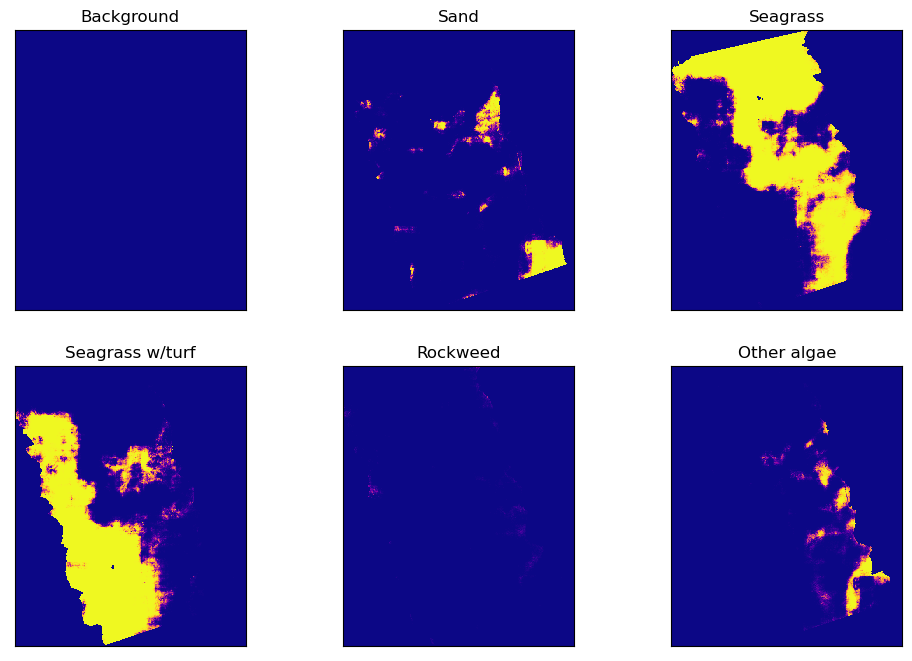

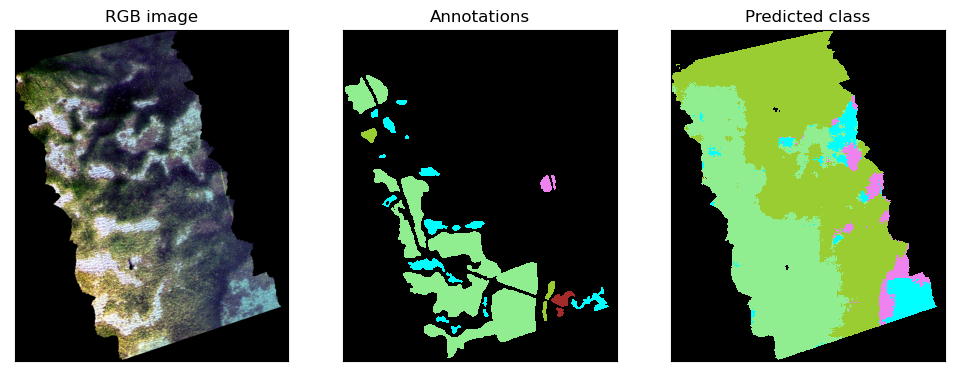


 Image OlbergholmenS_Pika_L_17-Radiance From Raw Data-Georectify Airborne Datacube.bip.hdr



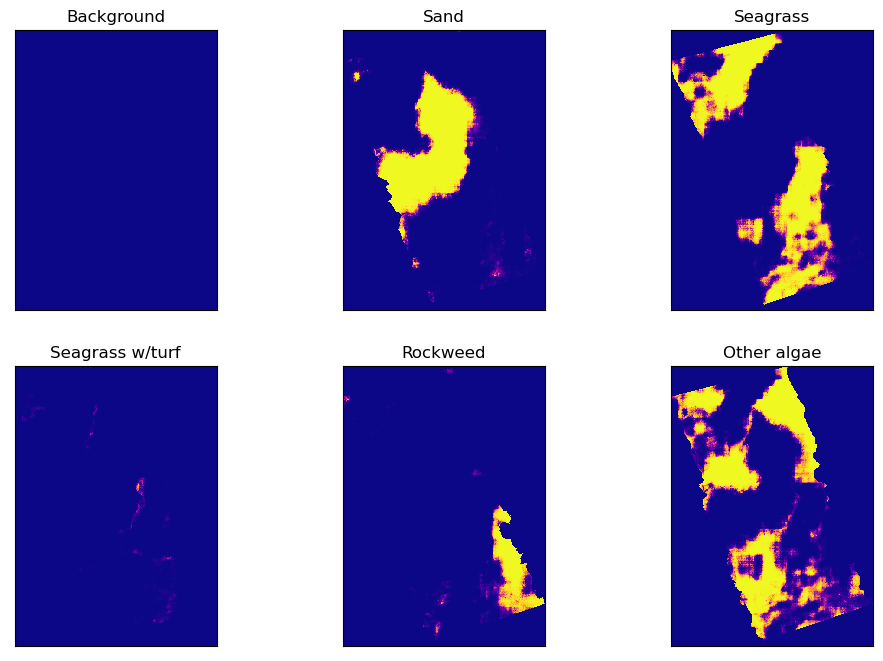

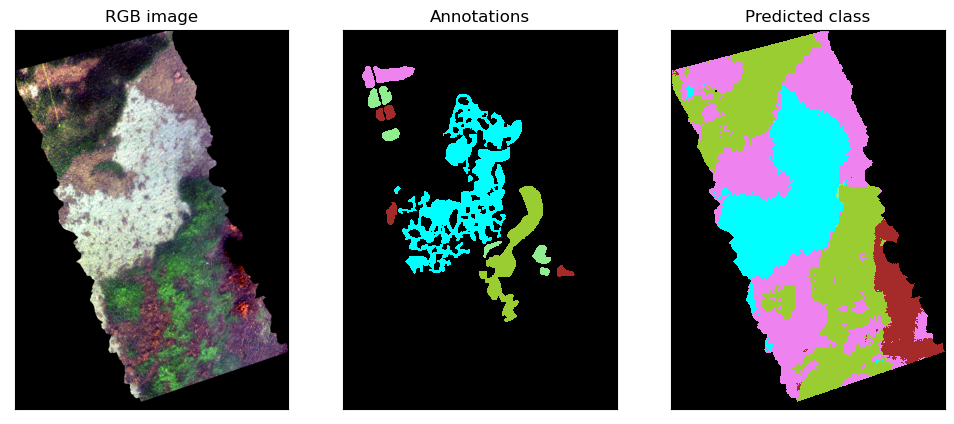

In [20]:
for im_num in range(len(im_pred_classified)):
    print(f'\n Image {hyspec_image_paths[im_num].name}\n')
    fig,((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(nrows=2,ncols=3,figsize=(12,8))
    axs = [ax0,ax1,ax2,ax3,ax4,ax5]
    for i in range(im_pred_likelihood[im_num].shape[2]):
        axs[i].imshow(im_pred_likelihood[im_num][:,:,i]*nonzero_masks[im_num],vmin=0,vmax=1,cmap='plasma',interpolation='none')
        axs[i].set_title(classes[i])
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    fig,(ax0,ax1,ax2) = plt.subplots(nrows=1,ncols=3,figsize=(12,8))
    ax0.imshow(rgb_images[im_num])
    ax0.set_title('RGB image')
    ax1.imshow(label_images[im_num]*nonzero_masks[im_num],vmin=0,vmax=6,cmap=custom_cmap,interpolation='none')
    ax1.set_title('Annotations')
    ax2.imshow(im_pred_classified[im_num]*nonzero_masks[im_num],vmin=0,vmax=6,cmap=custom_cmap,interpolation='none')
    ax2.set_title('Predicted class')
    for ax in (ax0,ax1,ax2):
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()



Observations:
- Some of the shallow sand areas in image 12 are classified as seagrass with turf algae. This could be due to a lack of sufficient examples of shallow sand mixed with some algae?
- Some of the smaller rockweed areas are not picked up in any of the images
- Image 17 has no "seagrass with turf algae" predictions. Perhaps because of deeper water and darker color?
- In image 17, "other algae" seems to have high activation across almost the entire image?
- Missing pixels seem to have a real impact on classifications. Consider inpainting PCA images.

In all, this isn't too bad!

Time to compare with e.g. random forest.

In [24]:
# Make confusion matrix based on test images
y_true = []
y_pred = []
for im_label_true, im_label_pred, nonzero_mask in zip(label_images,im_pred_classified, nonzero_masks):
    annotated_mask = (im_label_true > 0)
    label_mask = nonzero_mask & annotated_mask
    y_true.append(im_label_true[label_mask])
    y_pred.append(im_label_pred[label_mask])
    # plt.imshow(im_label_true)
    # plt.show()
    # plt.imshow(label_mask)
    # plt.show()
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
confusion_matrix = sklearn.metrics.confusion_matrix(y_true,y_pred,normalize='true')

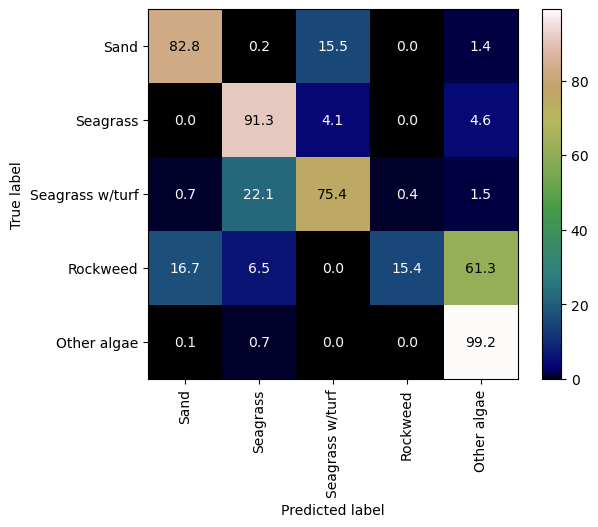

In [25]:
# Show confusion matrix
display_labels = ['Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix*100,display_labels=display_labels)
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.show()

Notes:
- Sand sometimes misclassified as seagrass with turf - I suspect this is because of water depth and perhaps a lack of shallow-water sand examples?
- Seagrass very well clasified...(!)
- Seagrass with turf often correctly classified (maybe because of water depth...?), and mostly misclassified as seagrass
- Rockweed very poorly classified, but there are also very few and small rockweed areas in the images.
- Other algae fairly well classified!